## Problem Definition

*Recognize Signs*
<img src="imgs/SIGNS.png" style="width:800px;height:300px;">

In [1]:
#necessary package
import numpy as np
import h5py
from keras.applications.vgg16 import VGG16 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from matplotlib import pyplot


Using TensorFlow backend.


In [0]:
batch_size = 32
num_classes = 6
epochs = 14

## Load Data

In [0]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
    
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [10]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


y = 3


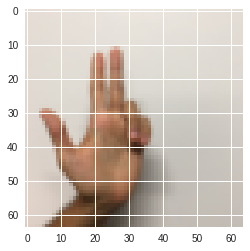

In [0]:
index = 564
pyplot.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [23]:
from google.colab import files

uploaded = files.upload()

Saving four_hand.jpg to four_hand.jpg


### Random Rotations

Sometimes images in your sample data may have varying and different rotations in the scene.

You can train your model to better handle rotations of images by artificially and randomly rotating images from your dataset during training.

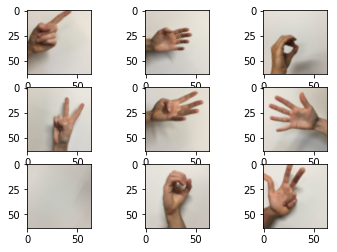

In [0]:
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(64,64,3))
    # show the plot
    pyplot.show()
    break

### Random Shifts

Objects in your images may not be centered in the frame. They may be off-center in a variety of different ways.

You can train your deep learning network to expect and currently handle off-center objects by artificially creating shifted versions of your training data. Keras supports separate horizontal and vertical random shifting of training data by the width_shift_range and height_shift_range arguments.

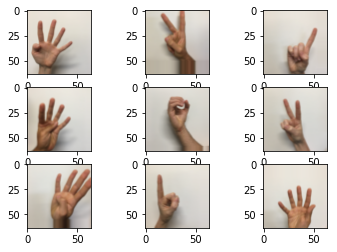

In [0]:
shift=0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(64,64,3))
    # show the plot
    pyplot.show()
    break

### Random Flips

Another augmentation to your image data that can improve performance on large and complex problems is to create random flips of images in your training data.
Keras supports random flipping along both the vertical and horizontal axes using the vertical_flip and horizontal_flip arguments

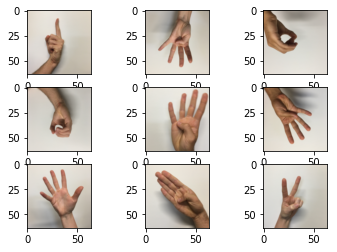

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(64,64,3))
    # show the plot
    pyplot.show()
    break

## Define Model
<img src="imgs/vgg16.png">

In [25]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
sign_model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False
#sign_model.summary()
# we chose to train the top one blocks, i.e. we will freeze
for layer in sign_model.layers[:15]:
     layer.trainable = False
for layer in sign_model.layers[15:]:
     layer.trainable = True
#sign_model.summary()
#Compile   

sign_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#training
model_info = sign_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, verbose=1)


Train on 1080 samples, validate on 120 samples
Epoch 1/14
1080/1080 [==============================] - 3s 2ms/step - loss: 1.2378 - acc: 0.4769 - val_loss: 0.5826 - val_acc: 0.8000
Epoch 2/14
1080/1080 [==============================] - 2s 2ms/step - loss: 0.3474 - acc: 0.8722 - val_loss: 0.2457 - val_acc: 0.9083
Epoch 3/14
1080/1080 [==============================] - 2s 2ms/step - loss: 0.1652 - acc: 0.9417 - val_loss: 0.2486 - val_acc: 0.9167
Epoch 4/14
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0935 - acc: 0.9694 - val_loss: 0.1168 - val_acc: 0.9667
Epoch 5/14
1080/1080 [==============================] - 2s 2ms/step - loss: 0.2506 - acc: 0.9306 - val_loss: 0.1873 - val_acc: 0.9167
Epoch 6/14
1080/1080 [==============================] - 2s 2ms/step - loss: 0.1827 - acc: 0.9481 - val_loss: 0.3652 - val_acc: 0.9000
Epoch 7/14
  96/1080 [=>............................] - ETA: 1s - loss: 0.2039 - acc: 0.94791080/1080 [==============================] - 2s 2ms/step 

In [26]:
# Final evaluation of the model
score = sign_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Baseline Error: %.2f%%" % (100-score[1]*100))

120/120 [==============================] - 0s 2ms/step
Test loss: 0.0653430496652921
Test accuracy: 0.9833333333333333
Baseline Error: 1.67%


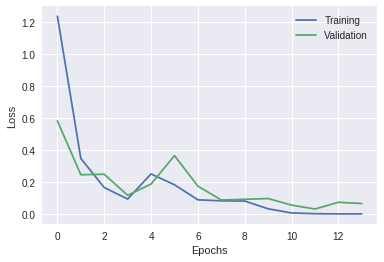

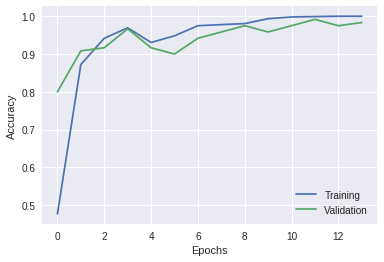

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(model_info)

In [0]:
sign_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

[[0. 0. 0. 0. 1. 0.]]


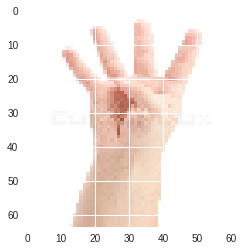

In [28]:
#Predict
img_path = 'imgs/four_hand.jpg'
img = image.load_img(img_path, target_size=(64, 64))
pyplot.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(sign_model.predict(x))